In [1]:
import qiskit

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister



from qiskit import IBMQ
from qiskit import Aer,BasicAer, execute, assemble
from qiskit.providers.aer import AerSimulator

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error,phase_damping_error


import numpy as np
from numpy import pi

import matplotlib as mpl
import matplotlib.pyplot as plt

from qiskit.tools.visualization import plot_histogram, plot_state_city

import qiskit.quantum_info as qi
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import partial_trace, Statevector




In [2]:
qreg_q = QuantumRegister(5, 'q')
creg_c = ClassicalRegister(1, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.rx(pi/2, qreg_q[0])
circuit.h(qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[1], qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[4])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[3])
circuit.h(qreg_q[0])
# circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.cz(qreg_q[0], qreg_q[4])
circuit.rx(-pi/2, qreg_q[4])
circuit.measure(qreg_q[4], creg_c[0])

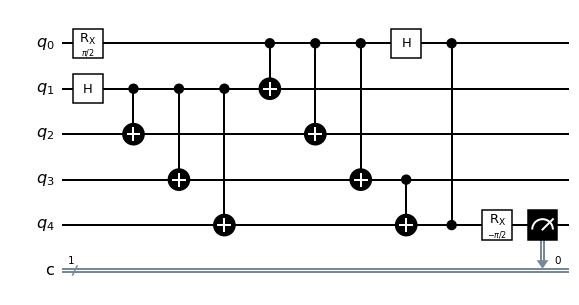

In [3]:
circuit.draw('mpl',style='bw')

In [9]:
# Исследуем ответ в идеальном случае - то есть на симуляторе 

In [10]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

In [11]:
job = backend.run(circuit)

In [13]:
retrieved_job = backend.retrieve_job(job.job_id())
result = retrieved_job.result() 

In [14]:
print(result.get_counts())

{'0': 4000}


In [15]:
# Запустим теперь наш алгоритм в реальный квантовый компьютер

In [26]:
backend = provider.get_backend('ibmq_quito') 

In [27]:
optimized_circuit = qiskit.transpile(circuit, backend)

In [28]:
# Запуск программы на реальном устройстве
job = backend.run(optimized_circuit)
retrieved_job = backend.retrieve_job(job.job_id())
result = retrieved_job.result() 
print(result.get_counts()) 

{'0': 2613, '1': 1387}


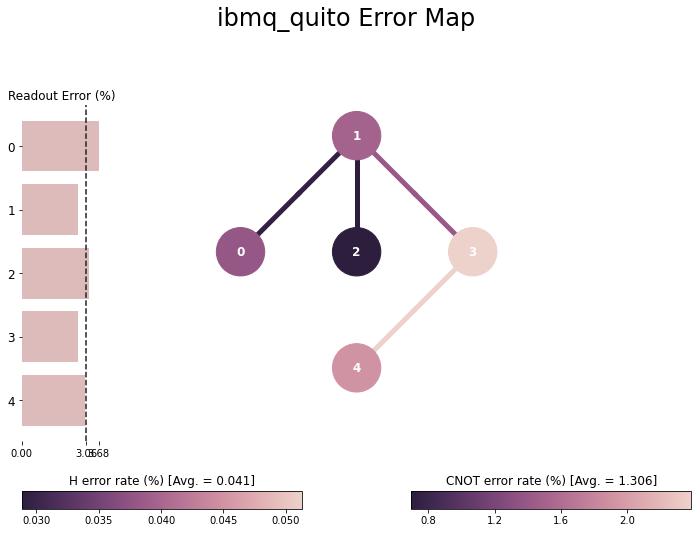

In [29]:
qiskit.visualization.plot_error_map(backend)

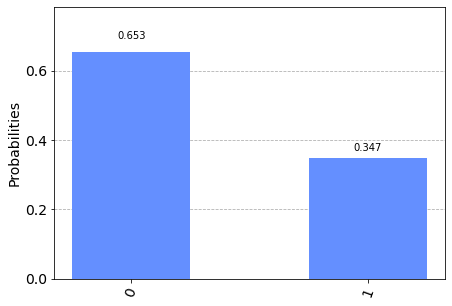

In [30]:
plot_histogram(result.get_counts()) 

In [31]:
backend = provider.get_backend('ibmq_santiago') 

optimized_circuit = qiskit.transpile(circuit, backend)

In [32]:
# Запуск программы на реальном устройстве
job = backend.run(optimized_circuit)
retrieved_job = backend.retrieve_job(job.job_id())
result = retrieved_job.result() 
print(result.get_counts()) 

{'0': 2425, '1': 1575}


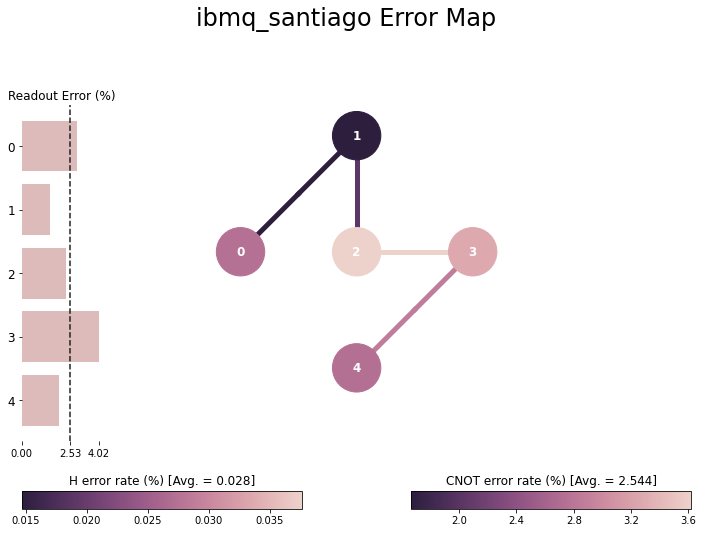

In [33]:
qiskit.visualization.plot_error_map(backend)

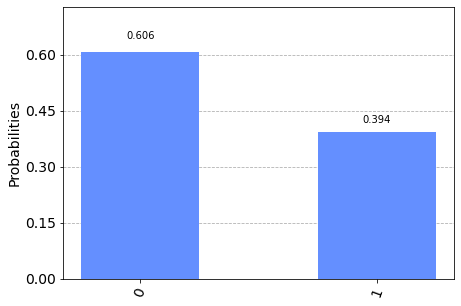

In [34]:
plot_histogram(result.get_counts()) 

In [ ]:
# Построим теперь модель с включенным шумом и исследуем ее поведение 

In [4]:
# Параметры ошибки деполяризации
# Вероятности ошибки
prob_1gate = 0.001  # Однокубитный гейт
prob_2gate = 0.01   # Двухкубитный гейт

# Ошибки деполяризации
error_1 = noise.depolarizing_error(prob_1gate, 1)
error_2 = noise.depolarizing_error(prob_2gate, 2)

In [5]:
# Добавление ошибок в модель
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

{'0': 3850, '1': 150}


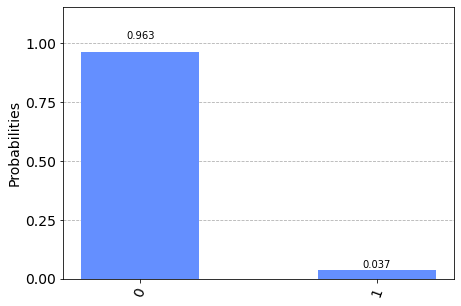

In [6]:
# Симуляция с шумом
result = execute(circuit, Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model,shots=4000).result()
counts = result.get_counts(0)
print(counts)
plot_histogram(counts)

In [7]:
# Параметры ошибки амплитудного затухания (Amplitude damping)
param_q0 = 0.05  # параметр затухания для кубита-0
param_q1 = 0.1   # параметр затухания для кубита-1

# Составляем ошибку ( действующую на двухкубитные операции)
qerror_q0 = amplitude_damping_error(param_q0)
qerror_q1 = amplitude_damping_error(param_q1)
cnot_error = qerror_q1.tensor(qerror_q0)

In [8]:
# Строим новую модель шума с ошибкой операции CNOT
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(cnot_error, 'cx')

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

{'0': 3188, '1': 812}


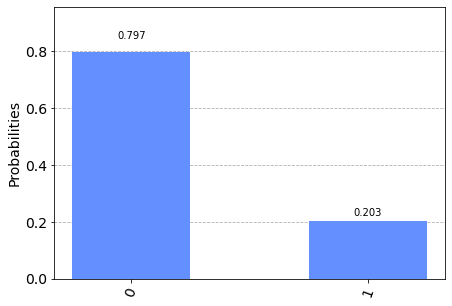

In [9]:
# Симуляция с шумом
result = execute(circuit, Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model, shots=4000).result()
counts = result.get_counts(0)
print(counts)
plot_histogram(counts)

In [10]:
# Параметры ошибки фазового затухания (Phase damping)
param_g0 = 0.05  # параметр затухания для кубита-0
param_g1 = 0.1   # параметр затухания для кубита-1

# Составляем ошибку ( действующую на двухкубитные операции)
qerror_g0 = phase_damping_error(param_g0)
qerror_g1 = phase_damping_error(param_g1)
cnot_error_phase = qerror_g1.tensor(qerror_g0)

In [11]:
# Строим новую модель шума с ошибкой операции CNOT
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(cnot_error_phase, 'cx')

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

{'0': 3354, '1': 646}


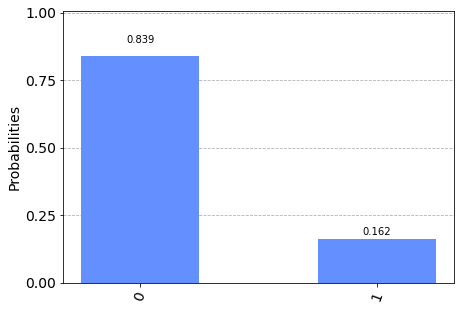

In [12]:
# Симуляция с шумом
result = execute(circuit, Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model, shots=4000).result()
counts = result.get_counts(0)
print(counts)
plot_histogram(counts)

In [14]:
def Counts_to_state_vec (counts) :
    state = [np.sqrt(counts['0']*1) , np.sqrt(counts['1']*1)]

    state = state/np.sqrt(counts['0']+counts['1'])
    state = state.tolist()
    return state

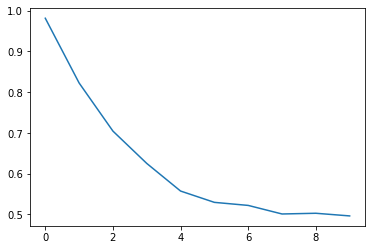

In [15]:
phase_damp_fidality = []
for i in range(1,100,10) :
    # Параметры ошибки фазового затухания (Phase damping)
    param_g0 = 0.005*i  # параметр затухания для кубита-0
    param_g1 = 0.01*i  # параметр затухания для кубита-1

    # Составляем ошибку ( действующую на двухкубитные операции)
    qerror_g0 = phase_damping_error(param_g0)
    qerror_g1 = phase_damping_error(param_g1)
    cnot_error_phase = qerror_g1.tensor(qerror_g0)
    
    # Строим новую модель шума с ошибкой операции CNOT
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(cnot_error_phase, 'cx')
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    # Симуляция с шумом
    result = execute(circuit, Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,shots=4000).result()
    counts = result.get_counts(0)
    phase_damp_fidality.append(qi.state_fidelity(Counts_to_state_vec(counts), [1,0]))
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([i for i in range(len(phase_damp_fidality))], phase_damp_fidality);  # Plot some data on the axes.    

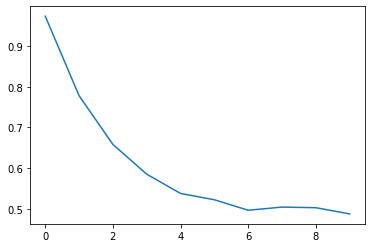

In [16]:
amp_damp_fidality = []
for i in range(1,100,10) :
    # Параметры ошибки амплитудного затухания (Amplitude damping)
    param_q0 = 0.005*i  # параметр затухания для кубита-0
    param_q1 = 0.01*i   # параметр затухания для кубита-1

    # Составляем ошибку ( действующую на двухкубитные операции)
    qerror_q0 = amplitude_damping_error(param_q0)
    qerror_q1 = amplitude_damping_error(param_q1)
    cnot_error = qerror_q1.tensor(qerror_q0)
    
    # Строим новую модель шума с ошибкой операции CNOT
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(cnot_error, 'cx')
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    # Симуляция с шумом
    result = execute(circuit, Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,shots=4000).result()
    counts = result.get_counts(0)
    amp_damp_fidality.append(qi.state_fidelity(Counts_to_state_vec(counts), [1,0]))
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([i for i in range(len(amp_damp_fidality))], amp_damp_fidality);  # Plot some data on the axes.  

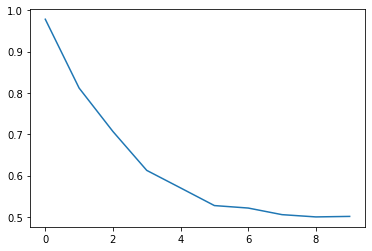

In [17]:
phase_damp_fidality = []
for i in range(1,100,10) :
    # Параметры ошибки фазового затухания (Phase damping)
    param_g0 = 0.005*i  # параметр затухания для кубита-0
    param_g1 = 0.01*i  # параметр затухания для кубита-1

    # Составляем ошибку ( действующую на двухкубитные операции)
    qerror_g0 = phase_damping_error(param_g0)
    qerror_g1 = phase_damping_error(param_g1)
    cnot_error_phase = qerror_g1.tensor(qerror_g0)
    
    # Строим новую модель шума с ошибкой операции CNOT
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(cnot_error_phase, 'cx')
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    # Симуляция с шумом
    result = execute(circuit, Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model,shots=4000).result()
    counts = result.get_counts(0)
    phase_damp_fidality.append(qi.state_fidelity(Counts_to_state_vec(counts), [1,0]))
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([i for i in range(len(phase_damp_fidality))], phase_damp_fidality);  # Plot some data on the axes.    